In [1]:
# pip install scikit-optimize

In [2]:
# pip install h5py

In [3]:
#pip install tensorflow==2.11

Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Load the data from the cleaned data source file

In [2]:
#Load dataset into a pandas dataframe
data = pd.read_csv("Cleaned data/data.csv") 

# don't really need to do this as this is cleaned data
data.dropna(inplace = True)

data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,32.2,21.95,38.472917,6665.366167,23.465,01-2016,4,0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,21.7,21.00,36.907292,6236.849955,23.465,01-2016,5,1
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,10.3,21.55,31.997083,6551.924748,23.465,01-2016,6,1
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,6.4,20.90,33.424583,6729.993123,23.465,01-2016,0,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,4.4,19.05,33.053958,7333.898202,23.465,01-2016,1,0


Drop the un-needed features

In [3]:
# df = data.drop(['MIN','MAX','FORECASTDEMAND', 'MONTHDATE','WEEKEND','RAIN'], axis=1)
df = data.drop(['MIN','MAX', 'MONTHDATE','WEEKEND'], axis=1)
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,WEEKDAY
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,6665.366167,23.465,4
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,6236.849955,23.465,5
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,6551.924748,23.465,6
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,6729.993123,23.465,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,7333.898202,23.465,1


In [4]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

One-hot encoding of categorical variables

In [5]:
# One-hot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df.copy()[['WEEKDAY']]

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
weekday_df.index= df.index

# # Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df, weekday_df], axis=1)

# #Drop the weekday column
df = df.drop(['WEEKDAY'], axis=1)

# df.dropna(inplace = True)
df.tail()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
DATE,,,,,,,,,,,,,,,,,,,
2022-07-28,2022,7,28,0.570217,21.608696,8712.672500,0.0,12.8,12.95,114.477308,8782.902714,183.255,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-07-29,2022,7,29,0.594186,16.209302,8850.636146,0.0,13.0,11.80,109.037174,9082.919122,183.255,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-07-30,2022,7,30,0.585238,24.642857,8601.131632,0.0,13.1,10.15,74.349286,8721.769989,183.255,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-07-31,2022,7,31,0.643333,12.769231,8699.873889,0.0,10.6,10.30,123.749503,8602.762027,183.255,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-08-01,2022,8,1,0.503784,20.297297,8027.280000,1.0,12.6,12.85,101.823779,8231.479437,222.545,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 2016-01-01 to 2022-08-01
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            2325 non-null   int64  
 1   MONTH           2325 non-null   int64  
 2   DAY             2325 non-null   int64  
 3   HUMIDITY        2325 non-null   float64
 4   WINDSPEED       2325 non-null   float64
 5   TOTALDEMAND     2325 non-null   float64
 6   HOLIDAY         2325 non-null   float64
 7   SOLAR           2325 non-null   float64
 8   TEMPAVE         2325 non-null   float64
 9   RRP             2325 non-null   float64
 10  FORECASTDEMAND  2325 non-null   float64
 11  OUTPUT          2325 non-null   float64
 12  MON             2325 non-null   float64
 13  TUE             2325 non-null   float64
 14  WED             2325 non-null   float64
 15  THU             2325 non-null   float64
 16  FRI             2325 non-null   float64
 17  SAT            

Split the dataset into training and testing sets
<br>Note: 
- training is from August 2017 - July 2021 (inclusive)
- testing is from August 2021 - July 2022 (inclusive) 

In [7]:
df_train = df[(df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1))]
df_test = df[df.index >= datetime(2021, 8, 1)]

demand_train_df = df_train[['TOTALDEMAND','FORECASTDEMAND']]
demand_test_df = df_test[['TOTALDEMAND','FORECASTDEMAND']]

df_train = df_train.drop(['FORECASTDEMAND'], axis=1)
df_test = df_test.drop(['FORECASTDEMAND'], axis=1)

train_X = df_train.copy()
train_y = df_train['TOTALDEMAND']

test_X = df_test.copy()
test_y = df_test['TOTALDEMAND']

print("number of training records",len(train_X))
print("number of test records",len(test_X))

feature_names = train_X.columns

X_train = train_X.values
y_train = train_y.values

X_test = test_X.values
y_test = test_y.values

number of training records 1417
number of test records 334


Normalize the data

In [8]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("X_train_scaled:", len(X_train_scaled))
print("X_test_scaled:", len(X_test_scaled))

scaler_Y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1))

print("y_train_scaled:", len(y_train_scaled))
print("y_test_scaled:", len(y_test_scaled))

X_train_scaled: 1417
X_test_scaled: 334
y_train_scaled: 1417
y_test_scaled: 334


Reshape the data for input to the LSTM model 

In [9]:
#(This step will fit the data to a 3D tensor format for the LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#we using sliding window approach to create input-output pairs with
#timesteps n=5 ie: from 6 days ago to the day before the current date

timesteps = 5

def create_sliding_windows(Xdata, yData, window_size):
    X, y = [], []
    for i in range(len(Xdata) - window_size - 1):
        X.append(Xdata[i : i + window_size])
        y.append(yData[i + window_size + 1])
    return np.array(X), np.array(y)

# Create sliding windows
X_train, y_train = create_sliding_windows(X_train_scaled, y_train_scaled.flatten(), timesteps)
X_test, y_test = create_sliding_windows(X_test_scaled, y_test_scaled.flatten(), timesteps)

input_dim = X_train.shape[2]
output_dim = 1

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (1411, 5, 18)
y_train:  (1411,)
X_test:  (328, 5, 18)
y_test:  (328,)


We use a Bayesian optimisation process to find the optimum combination of hyperparameters for this model
(Note: we are using the scikit-optimize library) 

In [10]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from skopt import gp_minimize
from skopt.space import Real, Integer, Space, Categorical
from skopt.utils import use_named_args

# Define a function to create the LSTM model
def create_lstm_model(lr, n_units1, n_units2, n_units3, dropout_rate1, dropout_rate2, dropout_rate3, activation1, activation2, activation3):
    model = Sequential()
    model.add(LSTM(units=n_units1, input_shape=(timesteps, input_dim), return_sequences=True, activation=activation1))
    model.add(Dropout(dropout_rate1))
    model.add(LSTM(units=n_units2, activation=activation2, return_sequences=True))
    model.add(Dropout(dropout_rate2))
    model.add(LSTM(units=n_units3, activation=activation3))
    model.add(Dropout(dropout_rate3))
    model.add(Dense(output_dim))

    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    
    return model

# Define the function to optimize
@use_named_args([
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units1'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units2'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units3'),
    Integer(0, 5, name='dropout_rate1'),
    Integer(0, 5, name='dropout_rate2'),
    Integer(0, 5, name='dropout_rate3'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation3')
])

def optimize_lstm(learning_rate, 
                  n_units1, n_units2, n_units3,    
                  dropout_rate1, dropout_rate2, dropout_rate3,
                  activation1, activation2, activation3):
    
    dropout_rate1 = dropout_rate1/10
    dropout_rate2 = dropout_rate2/10
    dropout_rate3 = dropout_rate3/10
    
    # Create the model
    model = create_lstm_model(learning_rate, 
                              n_units1, n_units2, n_units3,  
                              dropout_rate1, dropout_rate2, dropout_rate3, 
                              activation1, activation2, activation3)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, batch_size=64, verbose=0, callbacks=[early_stopping])
    
    # Get the validation MAE from the last epoch
    val_mae = history.history['val_mae'][-1]
    
    return val_mae


start_time = time.perf_counter()

# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Define the search space
search_space = Space([
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units1'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units2'),
    Categorical([16, 32, 64, 128, 256, 512, 1024], name='n_units3'),
    Integer(0, 5, name='dropout_rate1'),
    Integer(0, 5, name='dropout_rate2'),
    Integer(0, 5, name='dropout_rate3'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation3')
])

# Run the Bayesian optimisation
result = gp_minimize(optimize_lstm, search_space, n_calls=50, random_state=42)

# extract the best hyperparameters
best_learning_rate, best_n_units1, best_n_units2, best_n_units3, best_dropout_rate1, best_dropout_rate2, best_dropout_rate3, best_activation1, best_activation2, best_activation3  = result.x

end_time = time.perf_counter()

print(f"Bayesian Optimisation time: {end_time - start_time:0.4f} seconds")

Bayesian Optimisation time: 4692.1679 seconds


In [11]:
best_dropout_rate1 = best_dropout_rate1/10
best_dropout_rate2 = best_dropout_rate2/10
best_dropout_rate3 = best_dropout_rate3/10

# Print the optimal hyperparameters
print(f"best_learning_rate = {best_learning_rate}")
print(f"best_n_units1 = {best_n_units1}")
print(f"best_n_units2 = {best_n_units2}")
print(f"best_n_units3 = {best_n_units3}")
print(f"best_activation1 = '{best_activation1}'")
print(f"best_activation2 = '{best_activation2}'")
print(f"best_activation3 = '{best_activation3}'")
print(f"best_dropout_rate1 = {best_dropout_rate1}")
print(f"best_dropout_rate2 = {best_dropout_rate2}")
print(f"best_dropout_rate3 = {best_dropout_rate3}")

best_learning_rate = 0.008112996696748703
best_n_units1 = 32
best_n_units2 = 64
best_n_units3 = 512
best_activation1 = 'sigmoid'
best_activation2 = 'sigmoid'
best_activation3 = 'sigmoid'
best_dropout_rate1 = 0.2
best_dropout_rate2 = 0.0
best_dropout_rate3 = 0.4


Build the final LSTM model with the optimal hyperparameters selected

In [12]:
# setup the model 
timesteps=X_train.shape[1]
input_dim=X_train.shape[2]
output_dim=1

# Build the LSTM model with 1 input layer, 2 hidden LSTM layers and one Dense output layer
# using the best combination of hyperparameters as derived above
model = Sequential()
model.add(LSTM(units=best_n_units1, input_shape=(timesteps, input_dim), return_sequences=True, activation=best_activation1))
model.add(Dropout(best_dropout_rate1))
model.add(LSTM(units=best_n_units2, activation=best_activation2, return_sequences=True))
model.add(Dropout(best_dropout_rate2))
model.add(LSTM(units=best_n_units3, activation=best_activation3))
model.add(Dropout(best_dropout_rate3))
model.add(Dense(output_dim))

optimizer=Adam(learning_rate=best_learning_rate)
model.compile(loss='mae', optimizer=optimizer)

In [13]:
#set the model to stop early if it appears to converge (decided on 20 iterations with no changes)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) 

# Train the LSTM model on the optimum model definition
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
23/23 [==============================] - 5s 46ms/step - loss: 1.4027 - val_loss: 0.1600
Epoch 2/50
23/23 [==============================] - 1s 28ms/step - loss: 0.1839 - val_loss: 0.1645
Epoch 3/50
23/23 [==============================] - 1s 25ms/step - loss: 0.1587 - val_loss: 0.1862
Epoch 4/50
23/23 [==============================] - 1s 27ms/step - loss: 0.1601 - val_loss: 0.1900
Epoch 5/50
23/23 [==============================] - 1s 25ms/step - loss: 0.1617 - val_loss: 0.1796
Epoch 6/50
23/23 [==============================] - 1s 27ms/step - loss: 0.1587 - val_loss: 0.1438
Epoch 7/50
23/23 [==============================] - 1s 27ms/step - loss: 0.1655 - val_loss: 0.1781
Epoch 8/50
23/23 [==============================] - 1s 28ms/step - loss: 0.1567 - val_loss: 0.2106
Epoch 9/50
23/23 [==============================] - 1s 30ms/step - loss: 0.1521 - val_loss: 0.1370
Epoch 10/50
23/23 [==============================] - 1s 27ms/step - loss: 0.1328 - val_loss: 0.1371
Epoch 11/

Run the prediction on the test set

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test)

11/11 [==============================] - 0s 6ms/step


In [15]:
# Evaluate the LSTM model on the test set
# Calculate MAE, MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Number of predictions: %d' % len(y_pred))
print('MAE: %.4f' % mae)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

Number of predictions: 328
MAE: 0.1106
MSE: 0.0185
R-squared: 0.4578


Plot the loss function (MAE) against the training and test data 

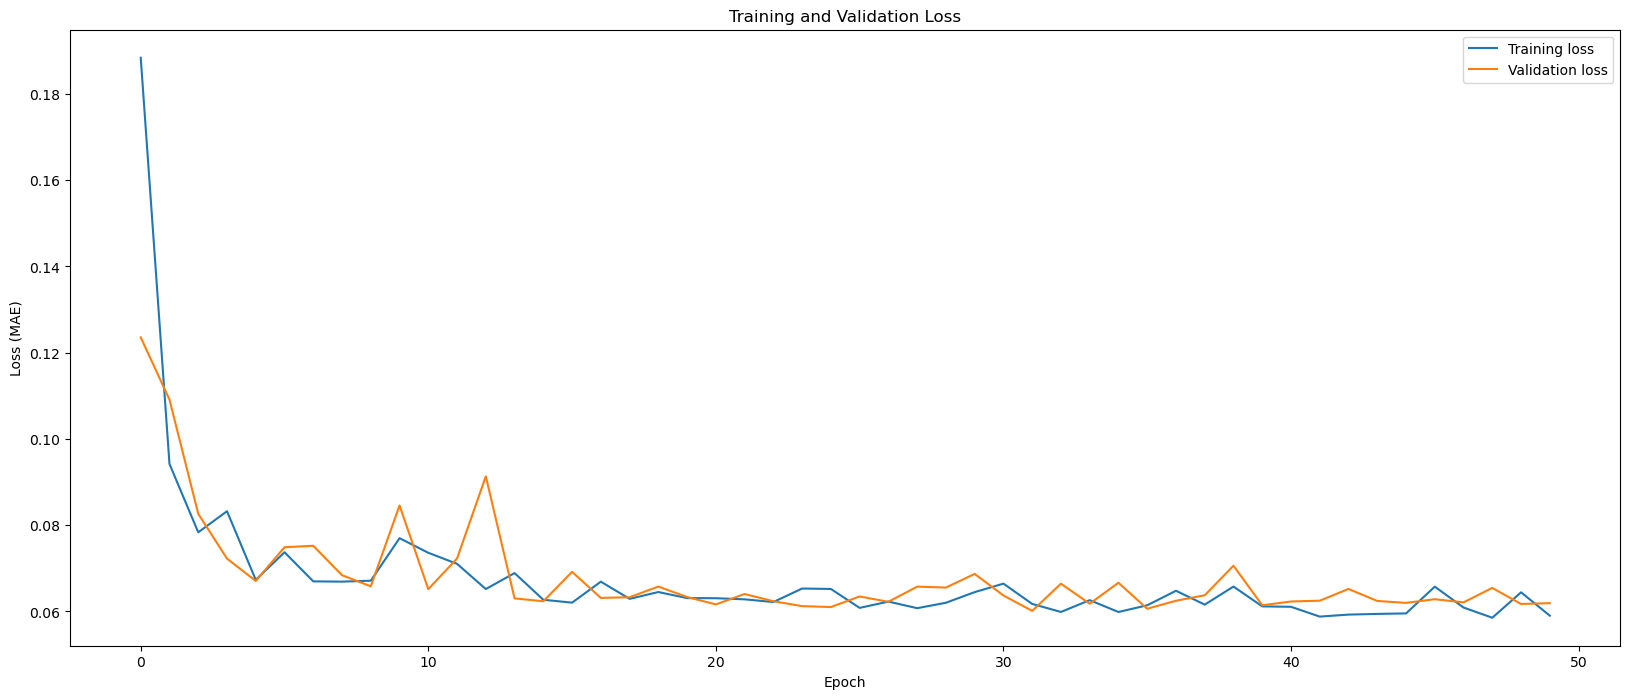

In [69]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [70]:
# revert the predicted values to actual values
y_pred_reverted = scaler_Y.inverse_transform(y_pred)

y_pred_reverted = list(y_pred_reverted.flatten())
y_pred_reverted.insert(0, None)

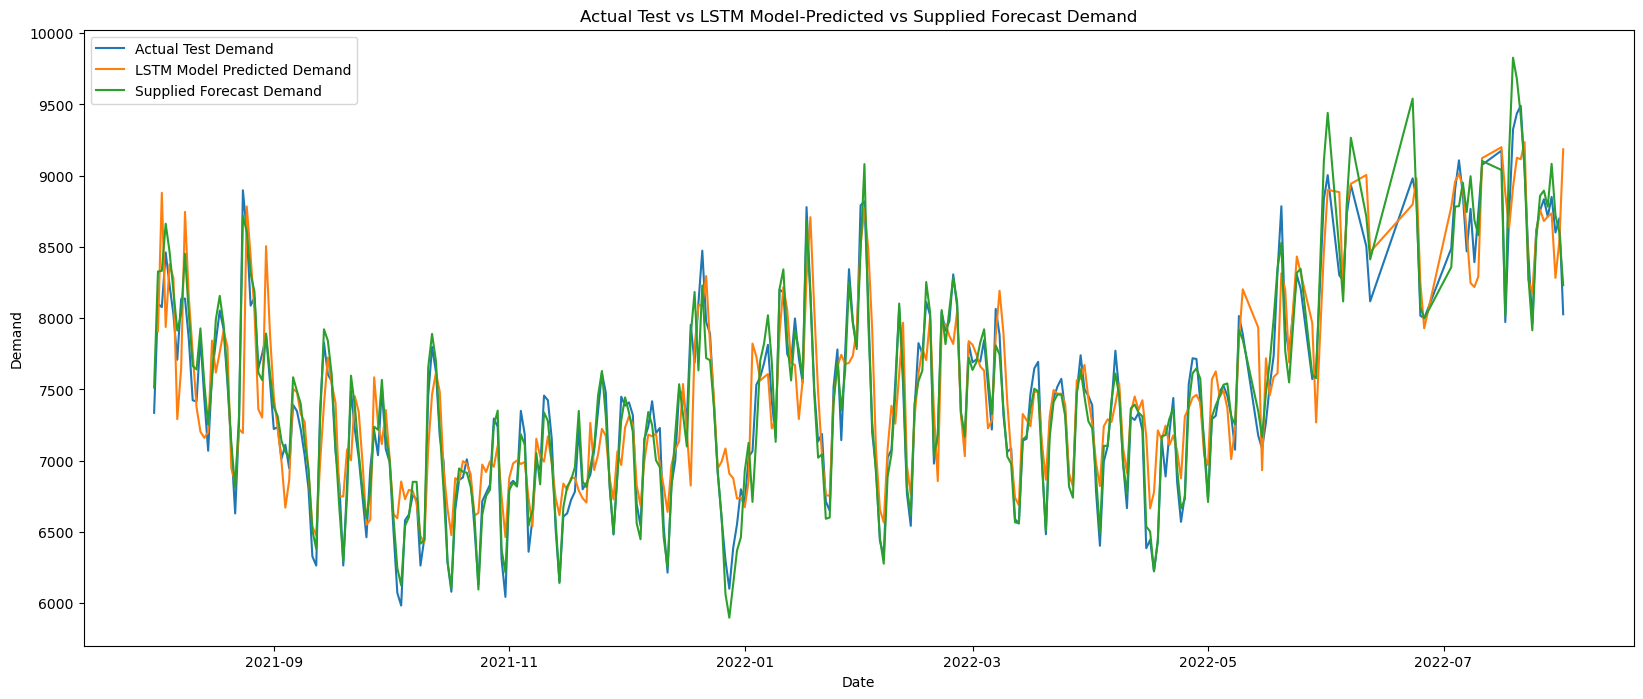

In [71]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('Actual Test vs LSTM Model-Predicted vs Supplied Forecast Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

Comparing the LSTM to the University supplied forecasts

In [72]:
print("LSTM Model Avg Actual Difference: ",(test_set_df.TOTALDEMAND - test_set_df.Pred_Demand).mean())

print("Supplied Model Avg Actual Difference: ",(test_set_df.TOTALDEMAND - test_set_df.FORECASTDEMAND).mean())

LSTM Model Avg Actual Difference:  -38.098416966849896
Supplied Model Avg Actual Difference:  -20.504155438119508


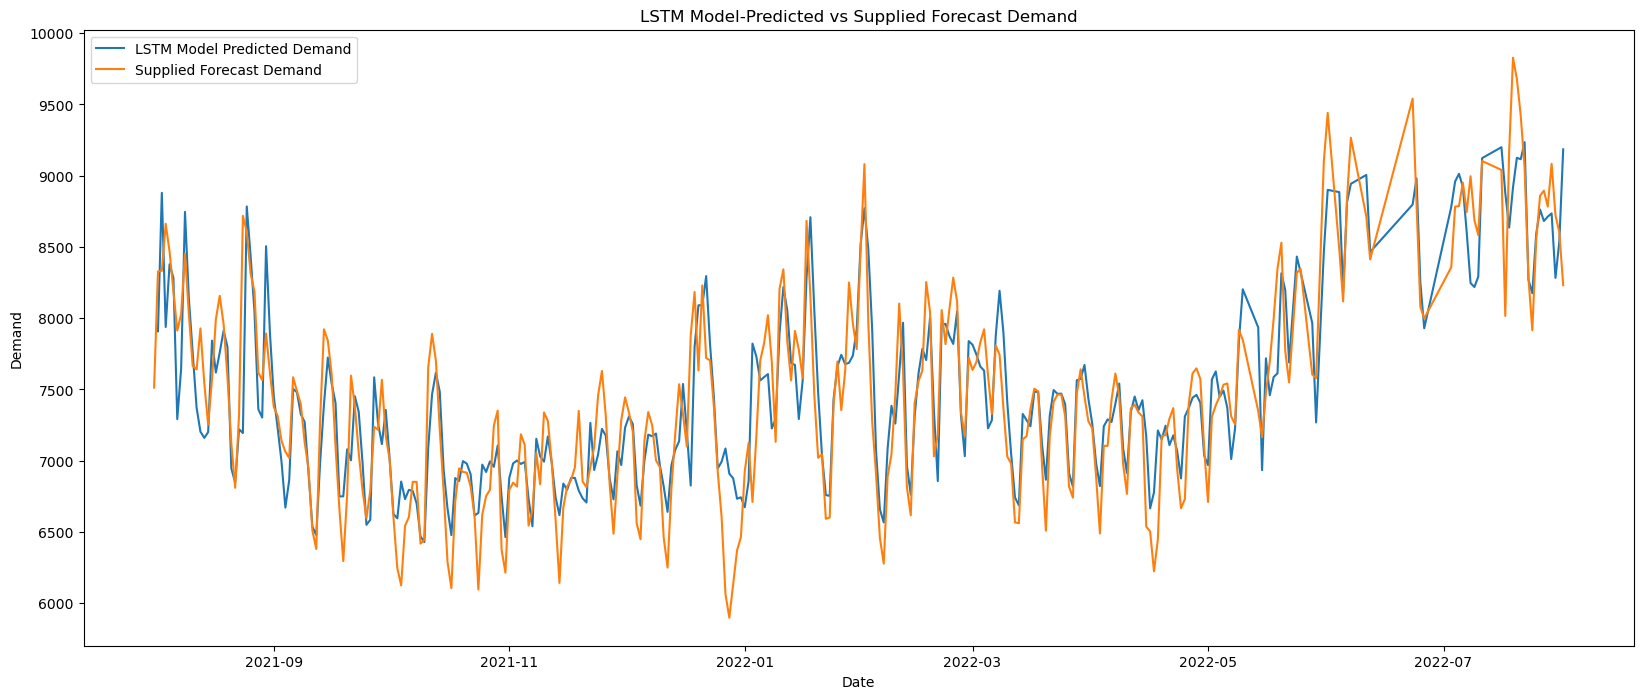

In [73]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
# plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('LSTM Model-Predicted vs Supplied Forecast Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

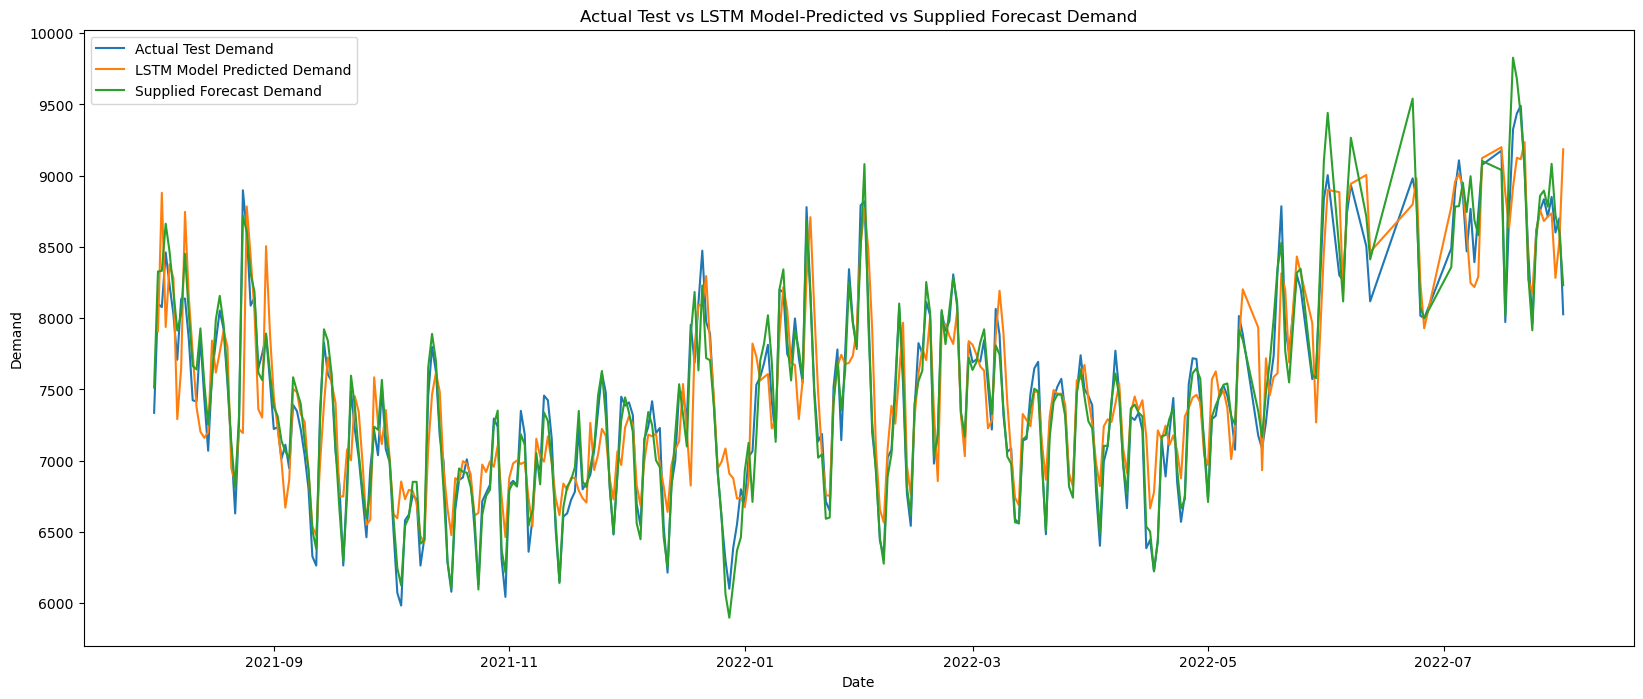

In [74]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('Actual Test vs LSTM Model-Predicted vs Supplied Forecast Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

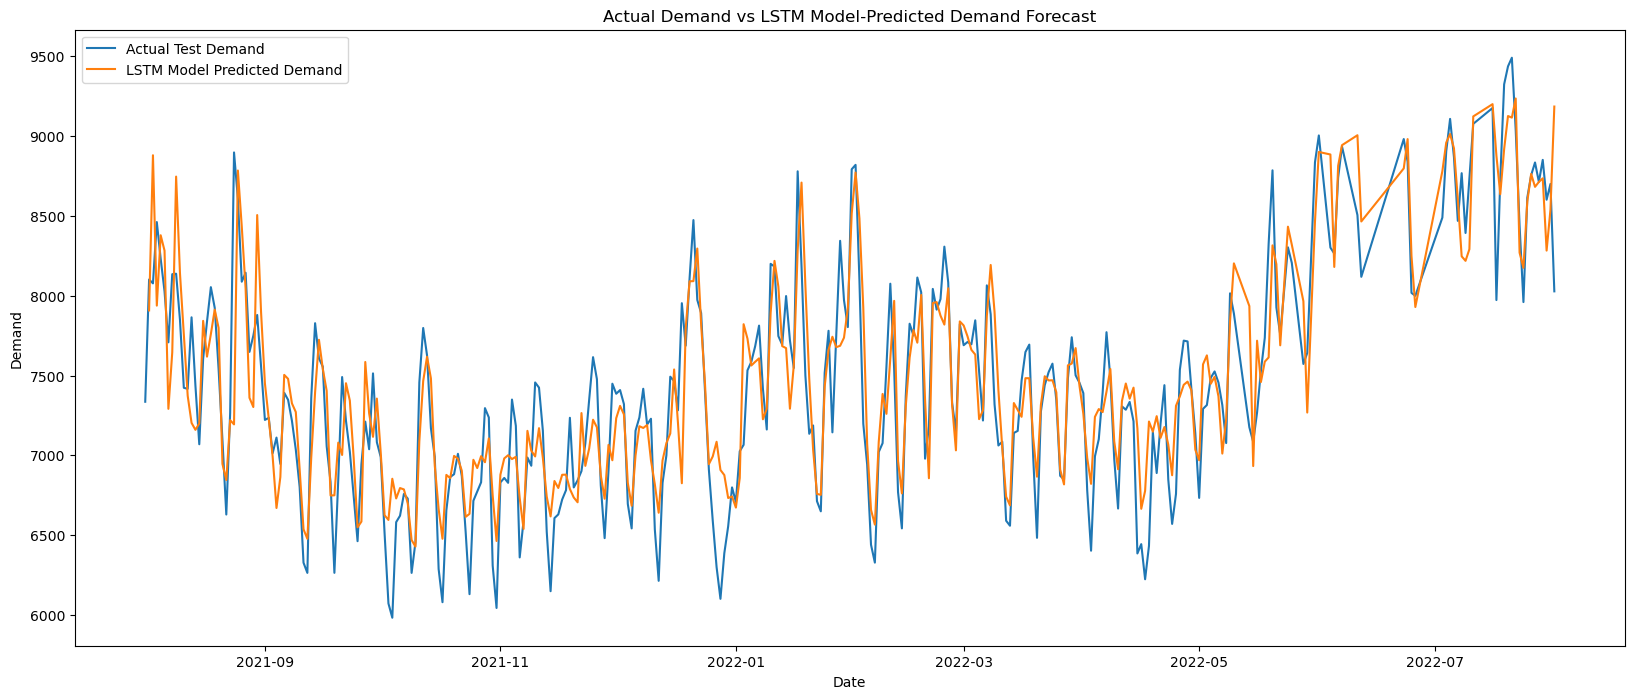

In [75]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
# plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('Actual Demand vs LSTM Model-Predicted Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [76]:
model.save("LSTM_including_TOTALDEMAND_model.h5")

Approximation Model

Try a Random Forest Regressor Approximation Model to work out feature importance of the results of the LSTM model

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import set_config 

In [78]:
df_test_copy = df_test.copy()

df_test_copy['Predicted_Demand'] = test_set_df['Pred_Demand']

df_test_copy.dropna(axis=0, inplace=True)
test_training = df_test_copy[(df_test_copy.index >= datetime(2021, 8, 1)) & (df_test_copy.index < datetime(2022, 6, 1))]
test_validation = df_test_copy[df_test_copy.index >= datetime(2022, 6, 1)]

scaler_Xtest = MinMaxScaler(feature_range=(0, 1))
X_train_test_scaled = scaler_Xtest.fit_transform(test_training.drop(['Predicted_Demand'], axis=1).values)
X_validation_test_scaled = scaler_Xtest.transform(test_validation.drop(['Predicted_Demand'], axis=1).values)

print("X_train_test_scaled:", len(X_train_test_scaled))
print("X_validation_test_scaled:", len(X_validation_test_scaled))

scaler_Ytest = MinMaxScaler(feature_range=(0, 1))
y_train_test_scaled = scaler_Ytest.fit_transform(test_training['Predicted_Demand'].values.reshape(-1, 1))
y_validation_test_scaled = scaler_Ytest.transform(test_validation['Predicted_Demand'].values.reshape(-1, 1))

print("y_train_test_scaled:", len(y_train_test_scaled))
print("y_validation_test_scaled:", len(y_validation_test_scaled))

rfr = RandomForestRegressor()

X_train_test_scaled_df = pd.DataFrame(X_train_test_scaled)
y_train_test_scaled_df = pd.DataFrame(y_train_test_scaled)

rfr.fit(X_train_test_scaled, y_train_test_scaled.flatten())

score = rfr.score(X_train_test_scaled, y_train_test_scaled.flatten())
print("R-squared:", score) 

X_train_test_scaled_df.columns = feature_names
feat_imp_df = pd.DataFrame(rfr.feature_importances_).T
feat_imp_df.columns = feature_names

feat_imp_df = feat_imp_df.T
feat_imp_df.columns = ['feature importance']

X_train_test_scaled: 296
X_validation_test_scaled: 37
y_train_test_scaled: 296
y_validation_test_scaled: 37
R-squared: 0.963261173599565


Display the Feature Importance which broadly reflects the LSTM model feature importance 

<Axes: title={'center': 'Feature Importance'}>

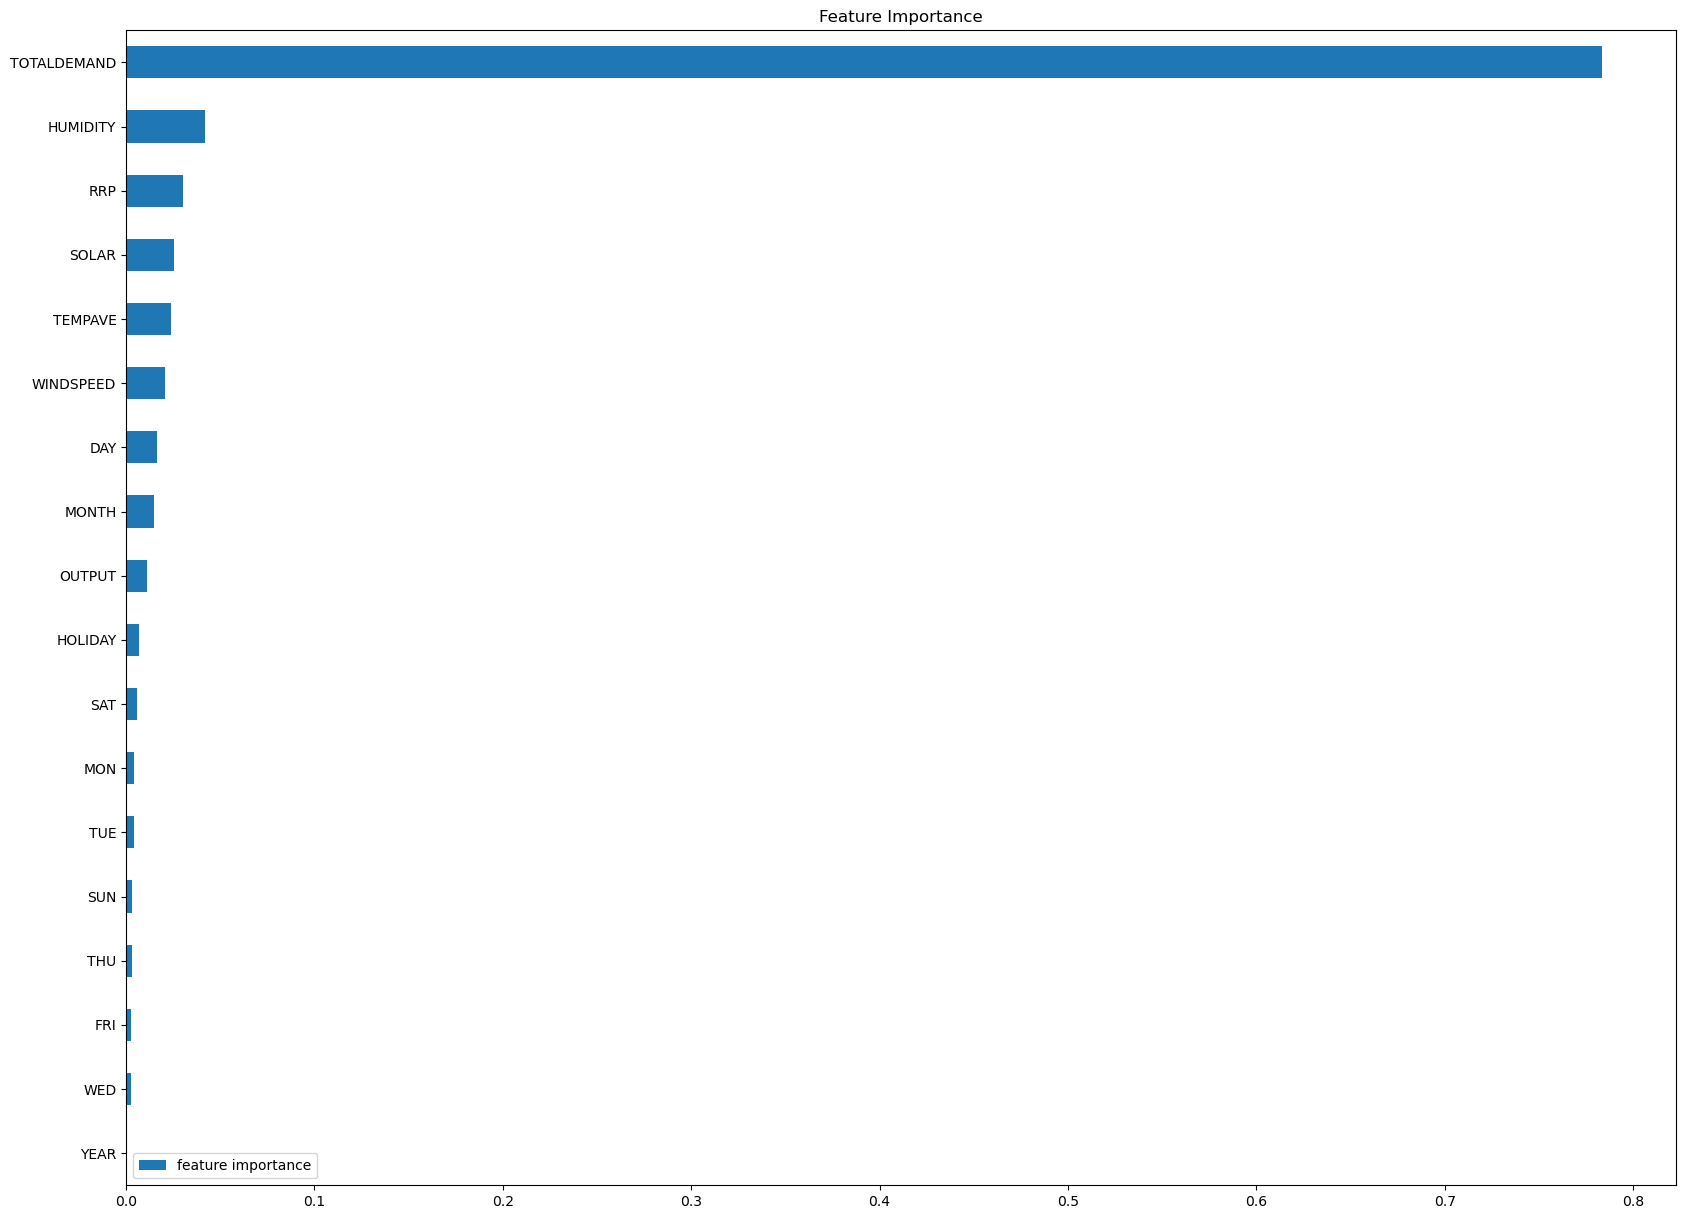

In [79]:
plt.rcParams["figure.figsize"] = (20,15)
feat_imp_df.sort_values(by='feature importance', ascending=True).plot.barh(title="Feature Importance")

In [80]:
feat_imp_df.sort_values(by='feature importance', ascending=False)

,feature importance
TOTALDEMAND,0.783591
HUMIDITY,0.042103
RRP,0.030231
SOLAR,0.025396
TEMPAVE,0.023662
WINDSPEED,0.020633
DAY,0.016166
MONTH,0.014887
OUTPUT,0.011069
HOLIDAY,0.006797


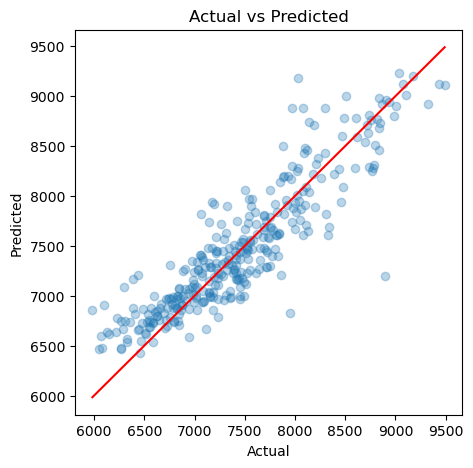

In [81]:
fig, ax = plt.subplots(figsize=(5,5))
Pred = test_set_df.Pred_Demand[1:]
Test = test_set_df.TOTALDEMAND
ax.scatter(test_set_df.TOTALDEMAND, test_set_df.Pred_Demand, label = 'Actual', alpha = 0.3)
ax.plot([max(max(Pred), max(Test)), min(min(Pred), min(Test))], [max(max(Pred), max(Test)), min(min(Pred), min(Test))], 'r-')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

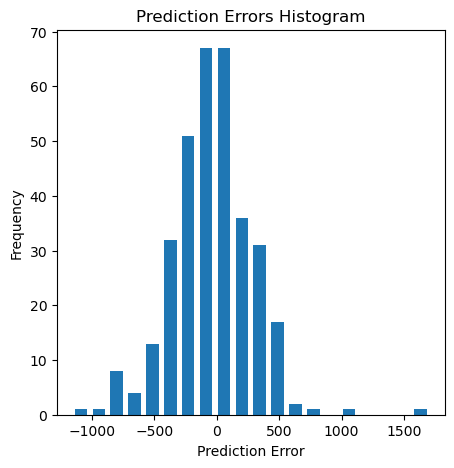

In [82]:
errors = Test - Pred
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(errors, bins=20, rwidth=0.7)
ax.set_title('Prediction Errors Histogram')
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Frequency')
plt.show() 

SHAP Analysis

In [83]:
import shap

In [84]:
X_train_test_scaled_df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,0.0,0.636364,0.033333,0.406839,0.403834,0.726916,1.0,0.342193,0.075000,0.287410,0.017987,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.636364,0.066667,0.520758,0.230903,0.718583,0.0,0.372093,0.252778,0.207030,0.017987,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.636364,0.100000,0.449692,0.384479,0.850345,0.0,0.385382,0.000000,0.307147,0.017987,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.636364,0.133333,0.264986,0.566183,0.771621,0.0,0.392027,0.125000,0.221288,0.017987,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.636364,0.166667,0.356875,0.367575,0.701451,0.0,0.392027,0.125000,0.298354,0.017987,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [85]:
# explain the model's predictions using SHAP values 
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X_train_test_scaled_df)

Visualise a single prediction

In [86]:
# visualise the first prediction's explanation
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_test_scaled_df.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

Visualise many predictions

In [87]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_test_scaled_df)

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

#### SHAP Summary Plot (bee-swarm plot)
Provides a density scatter plot of SHAP values for each feature to identify how much impact each featyre has on the model output for the validation dataset. Features are sorted by the sum of the SHAP value magnitudes. Note, when the scatter points don't fit on a line they pile up to show density, and the colour of each point represents the feature value of that point.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


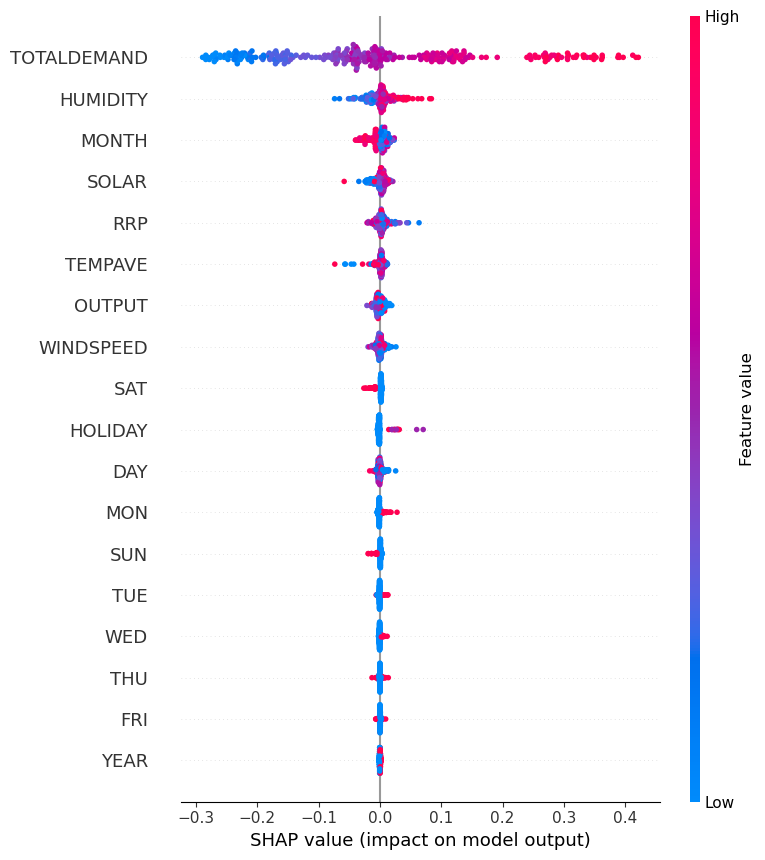

In [88]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_test_scaled_df)

#### Bar chart of mean importance
We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

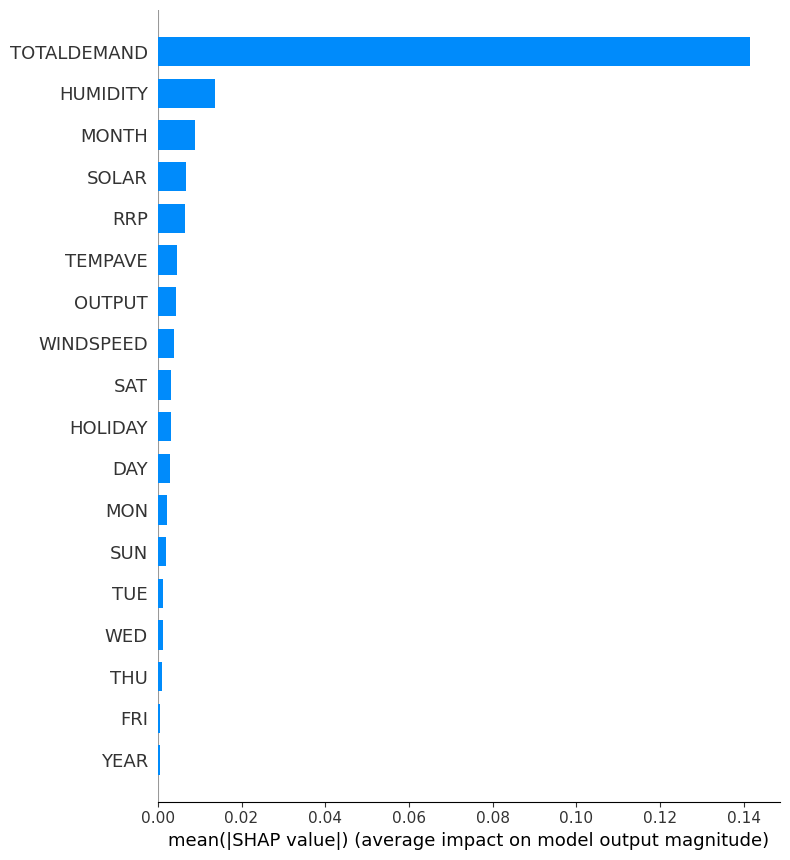

In [89]:
shap.summary_plot(shap_values, X_train_test_scaled_df, plot_type="bar")

#### SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

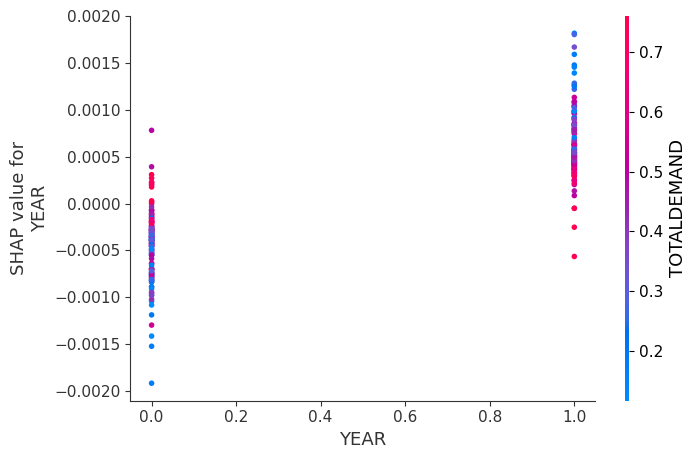

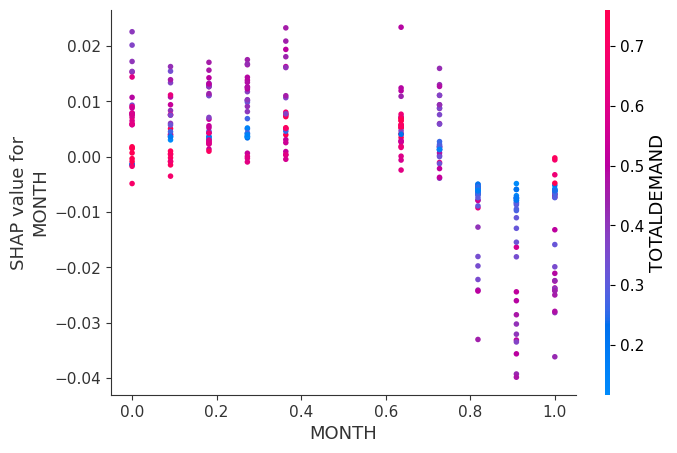

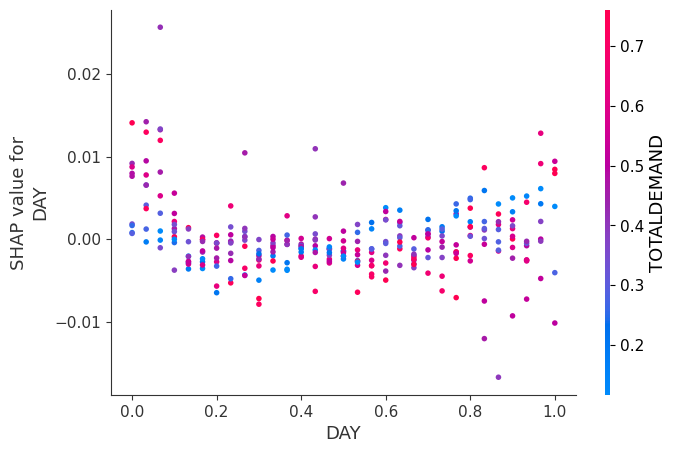

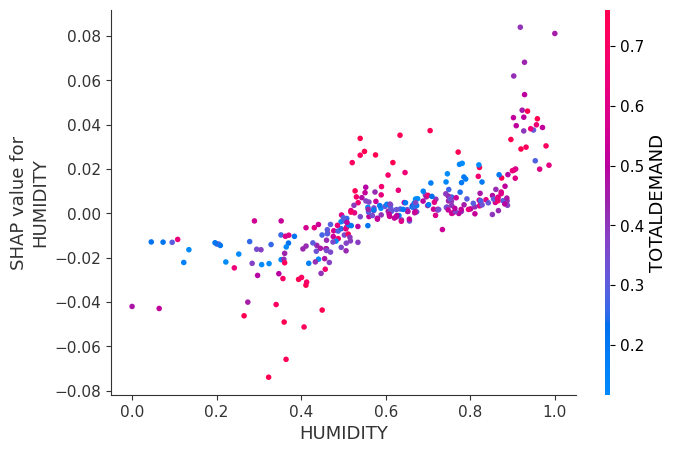

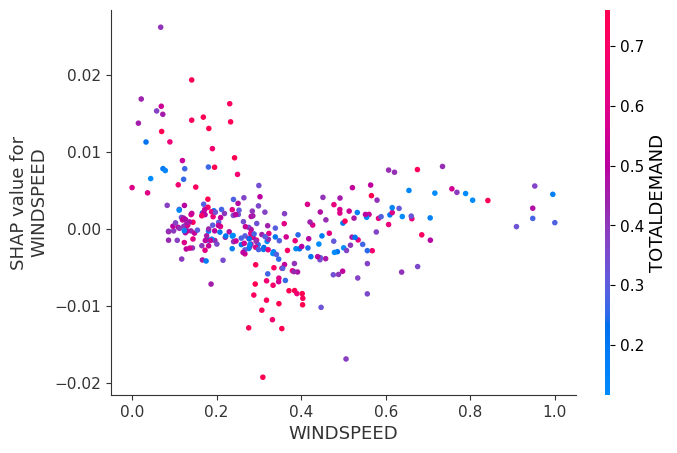

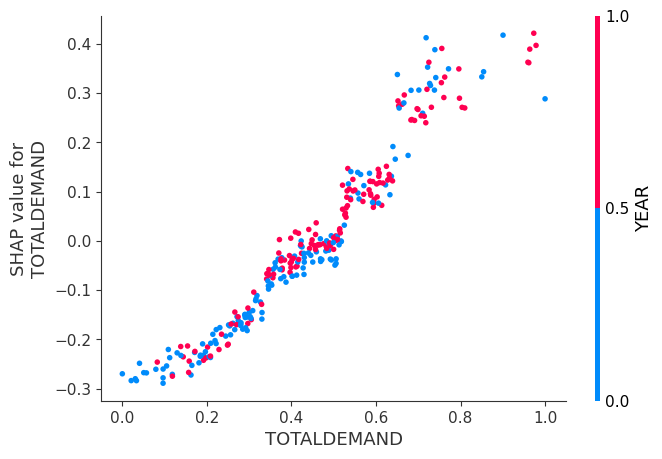

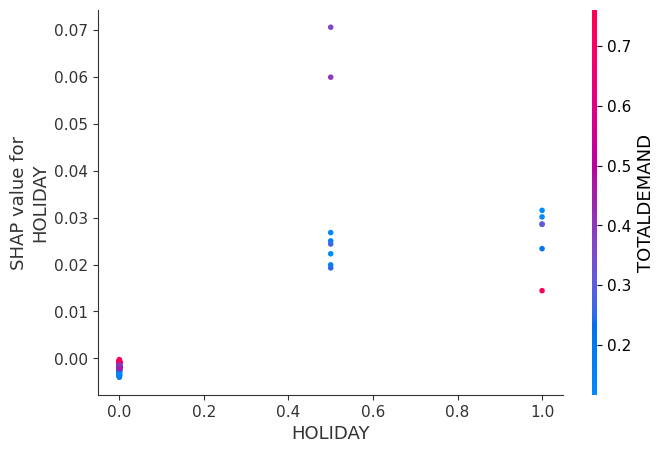

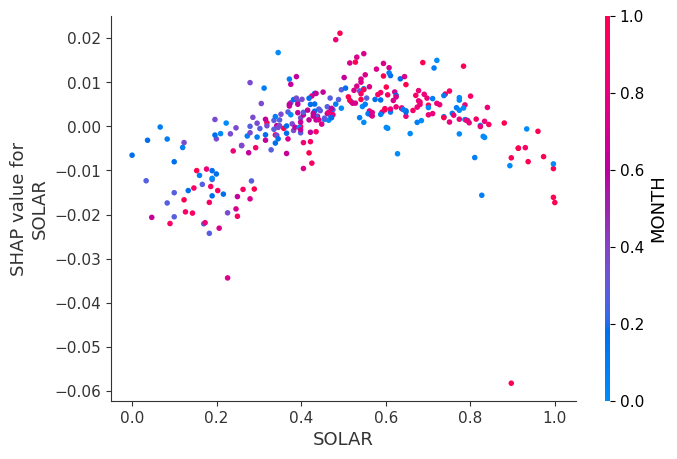

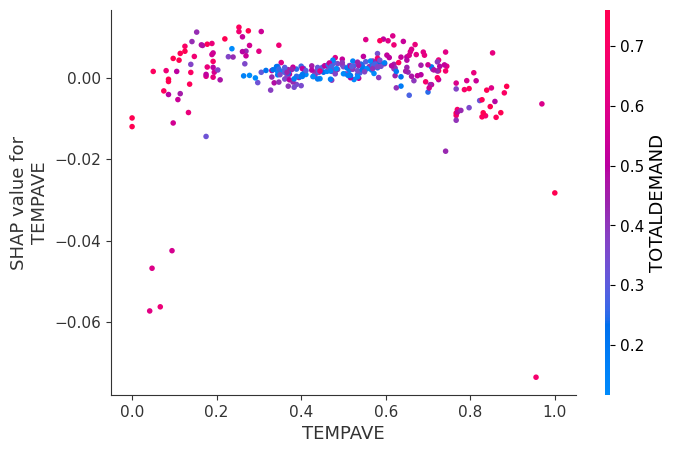

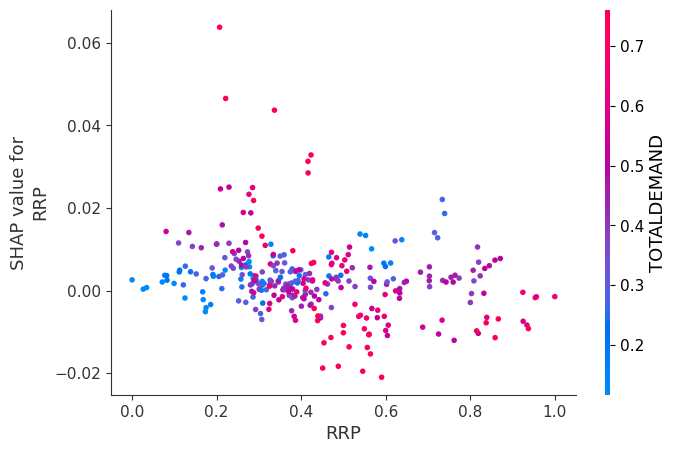

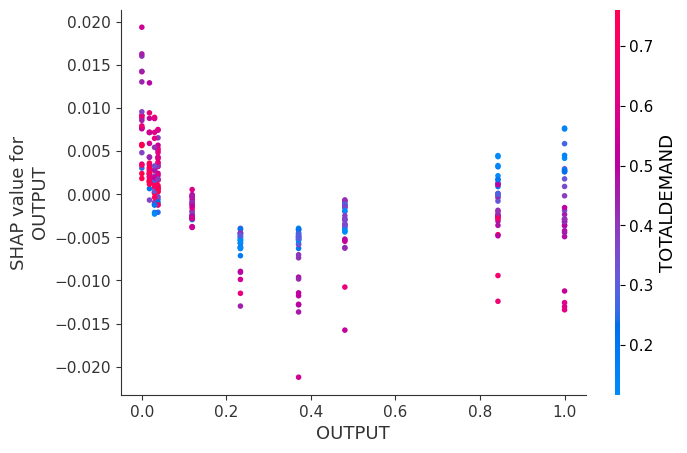

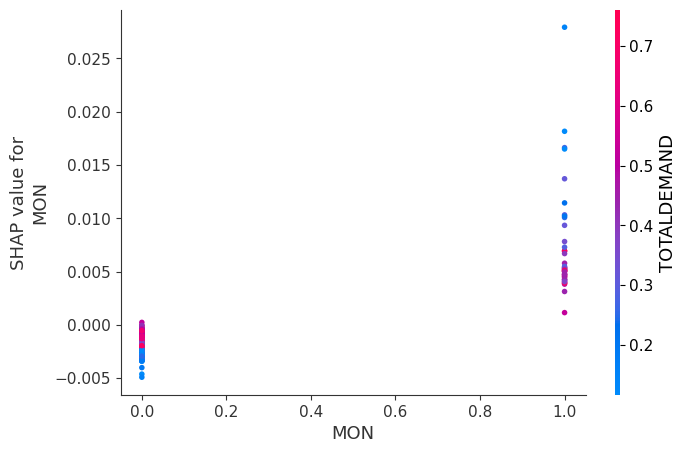

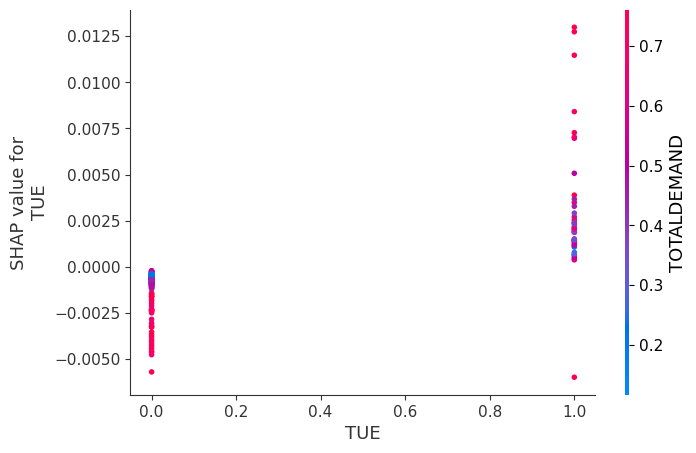

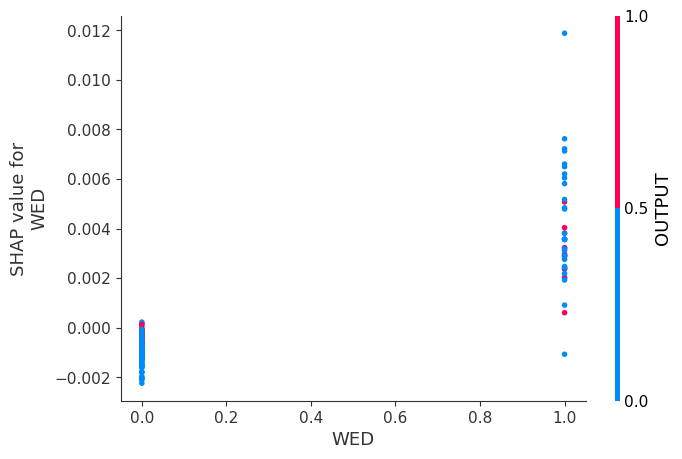

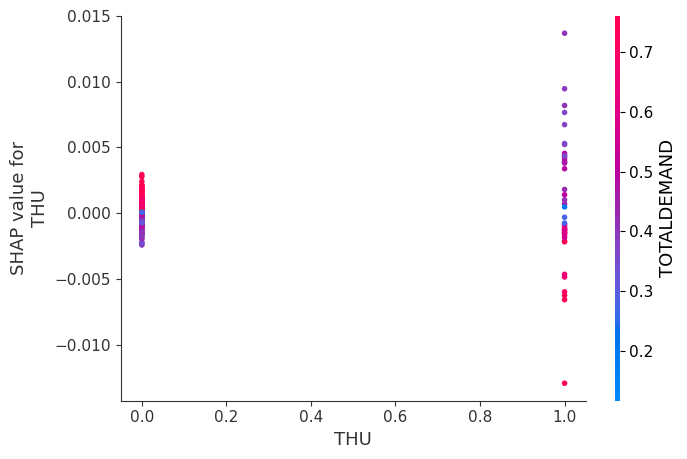

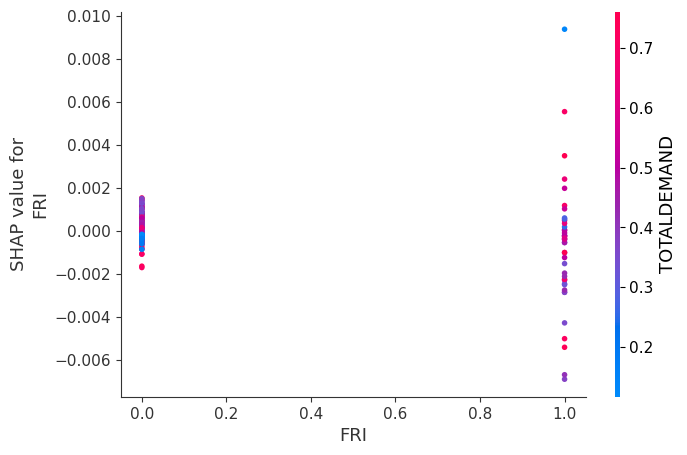

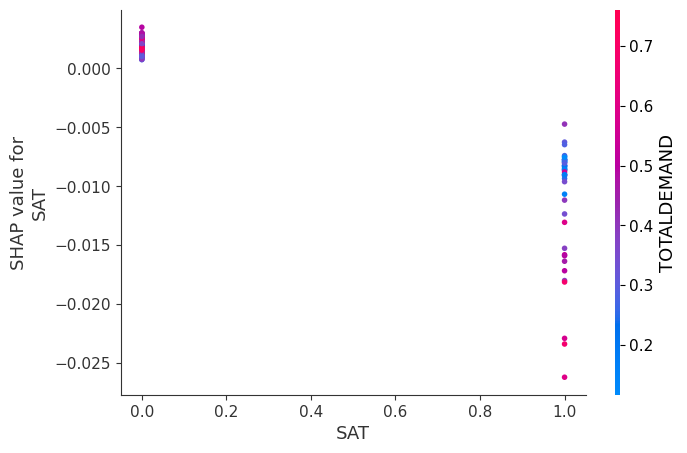

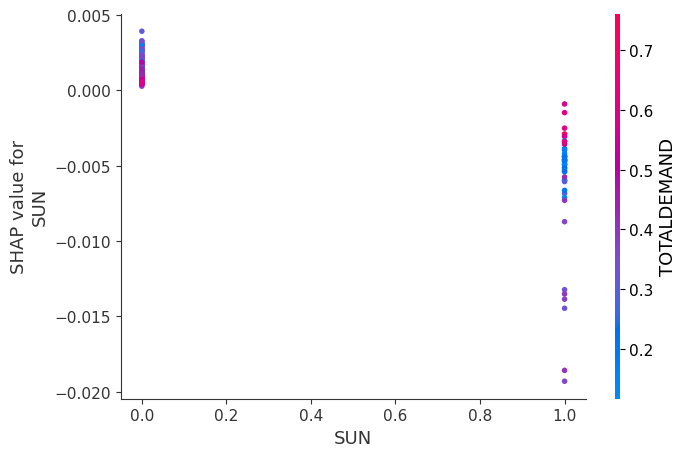

In [90]:
for name in X_train_test_scaled_df.columns:
    shap.dependence_plot(name, shap_values, X_train_test_scaled_df)

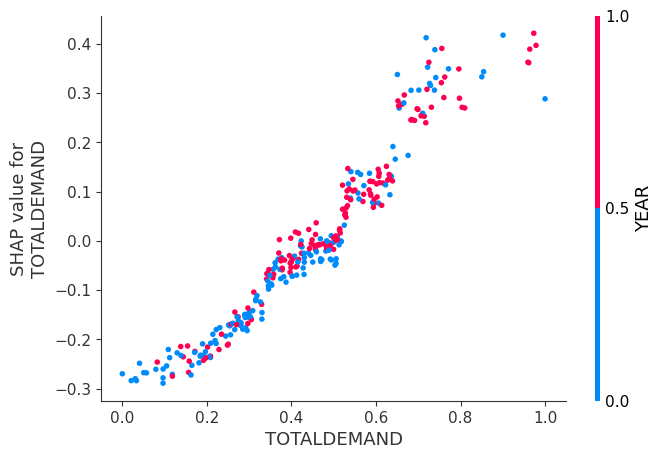

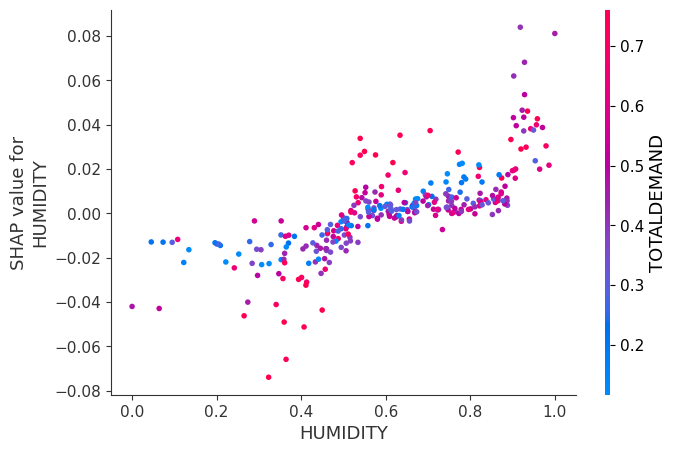

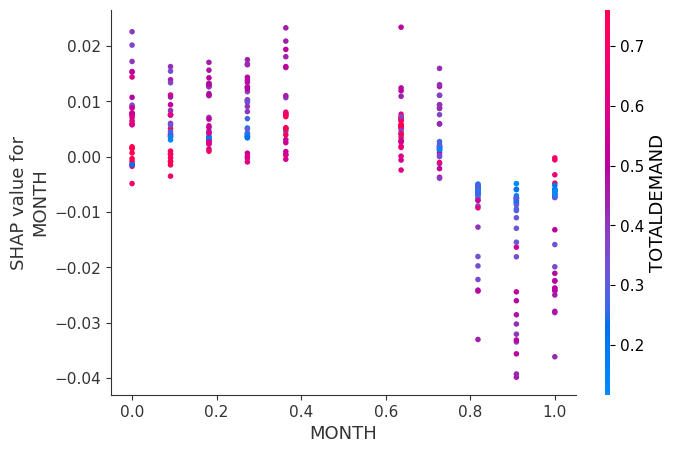

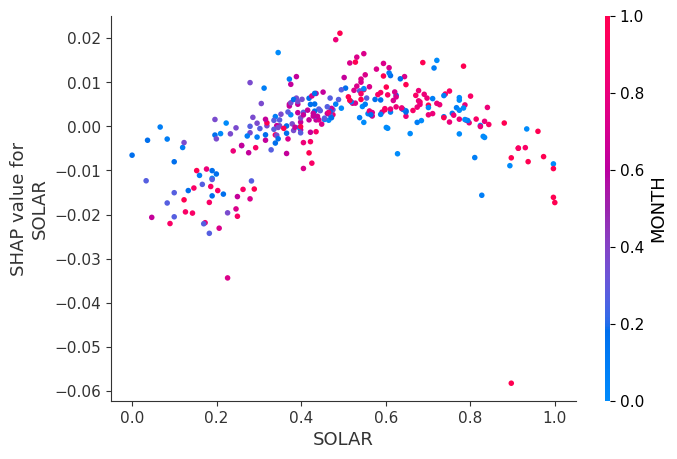

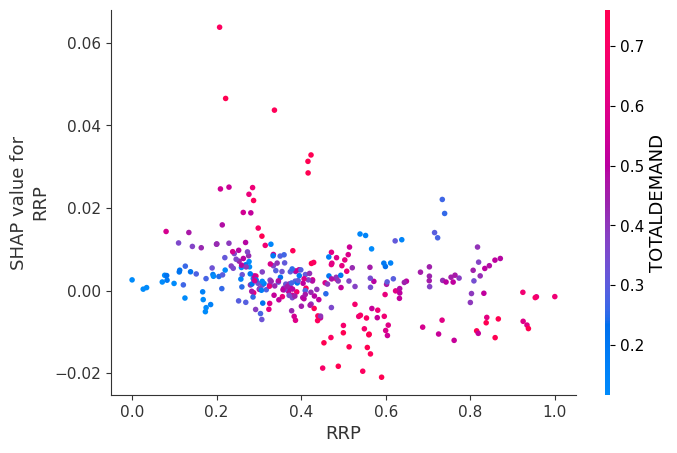

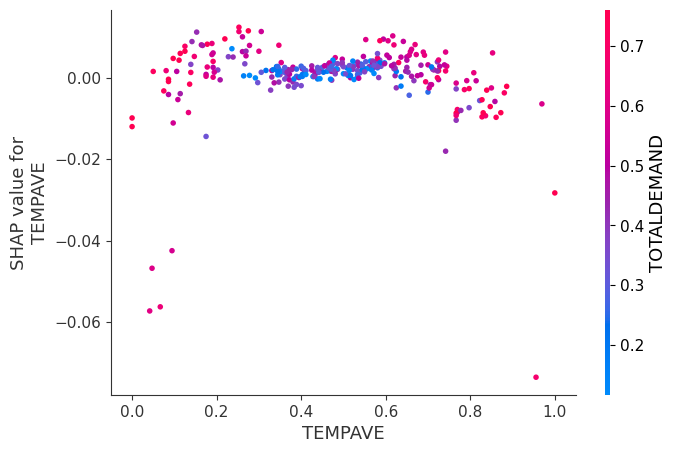

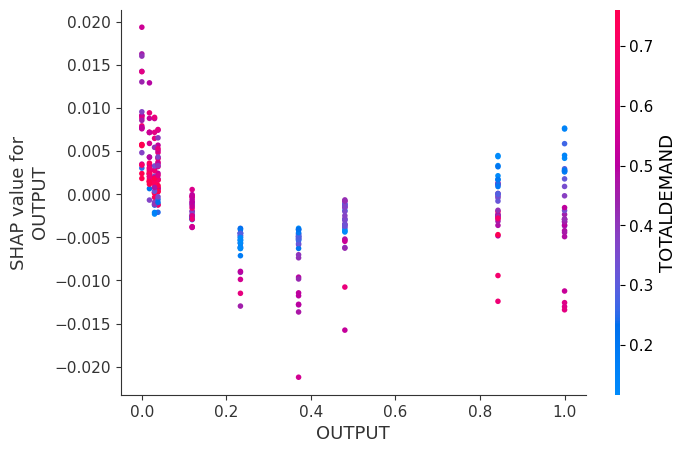

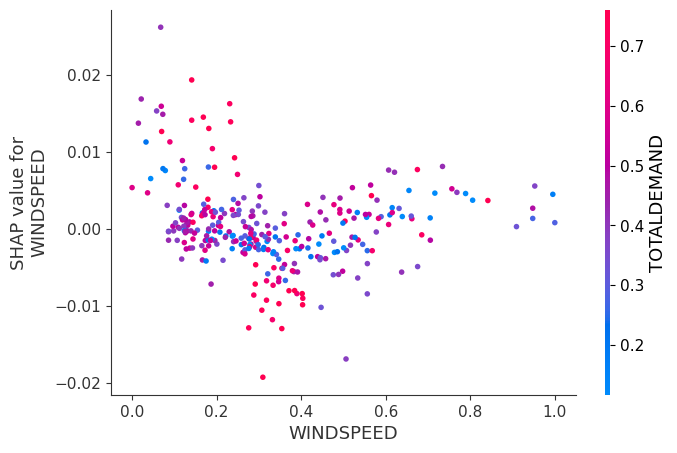

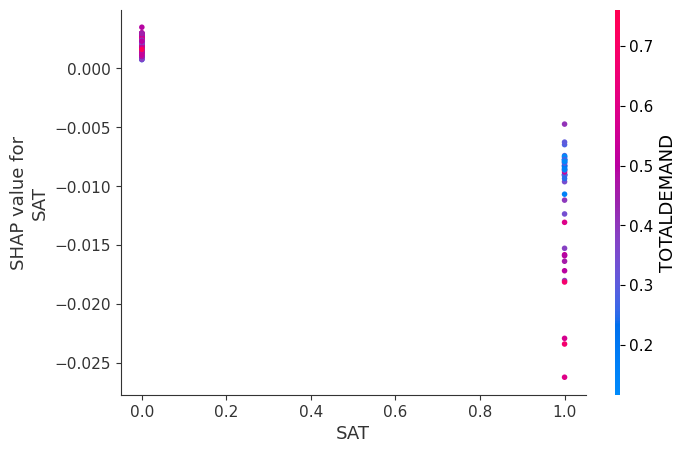

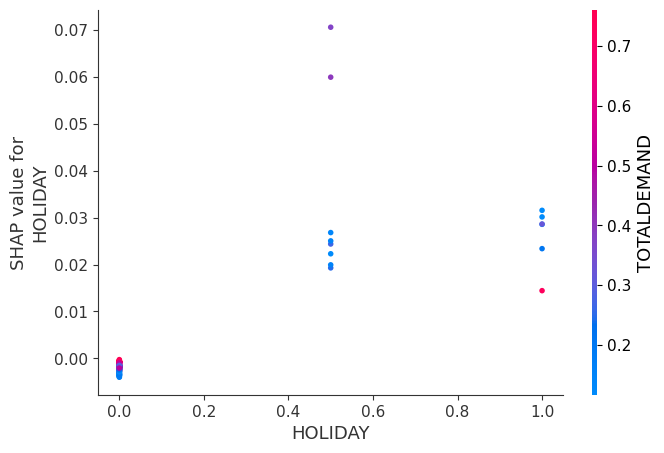

In [91]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the top 10 most important features
for i in range(10):
    shap.dependence_plot(top_inds[i], shap_values, X_train_test_scaled_df)

The dependence plot for the top feature, TOTALDEMAND, shows that the Random Forest Regressor (LSTM) captured most of the linear relationship. 